In [3]:
import numpy as np
from scipy.integrate import odeint

In [4]:
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1,k2,k3,a1,a2,a3=params
    #for now we are setting a, g, n, b dm, dp to be constant
    g1 = g2 = g3 = 0.024884149937163258
    n1 = n2 = n3 = 5.
    b1 = b2 = b3 = 33.82307682700831
    dm1 = dm2 = dm3 =1.143402097500176
    dp1 = dp2 = dp3 = 0.7833664565550977
    dm1dt = -dm1*m1 + (a1 / (1 + ((1/k1) * p2)**n1)) + g1
    dp1dt = (b1*m1) - (dp1*p1)
    dm2dt = -dm2*m2 + (a2 / (1 + ((1/k2) * p3)**n2)) + g2
    dp2dt = (b2*m2) - (dp2*p2)
    dm3dt = -dm3*m3 + (a3 / (1 + ((1/k3) * p1)**n3)) + g3
    dp3dt = (b3*m3)-(dp3*p3)
    return np.array([dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt])

In [5]:
def solve_ode(params):
    initial_conditions = np.array([0, 2, 0, 1, 0, 3])
    solution = odeint(model, initial_conditions, t=np.linspace(0,100,100), args=(params,)) # The initial value point should be the first element of this sequence
    return solution

In [6]:
timepoints = int(100)
third = int(timepoints / 3)
#truncated_traj = true_data[third:timepoints,:]

In [7]:
from scipy.signal import find_peaks

def summarise(solution):
    """Calculate summary statistics
        requires solution to be the result of calling solve_ode[parameters]
        e.g. true_data
        Returns
        -------
        a 1D array of summary statistics containing the mean of solution, the log variance of solution, the autocorrelation at lag 10, cross correlation of mRNA and protein species separately, number of peaks
        """
    mean=np.mean(solution, axis=0)
    var=np.var(solution, axis=0)
    #The autocorrelation coefficient of each time series at lag 10 and lag 5
    #can be altered
    auto_cor=np.corrcoef(solution[10:,:], solution[:-10,:], rowvar=False)[6:,:]
    auto_cor_coef=np.diag(auto_cor)
    cor=np.corrcoef(solution, solution, rowvar=False)[:6,2:8]
    cor_coef=np.diag(cor)
    #returning cross correlation coefficients of mRNA to mRNA species, protein to protein species
    truncated_trajectory=solution[third:timepoints,:]
    peaks,_=zip(*(find_peaks(truncated_trajectory[:,i], height=0) for i in range(6)))
    peak_count=np.array([len(p) for p in peaks])
    return(np.concatenate([mean, var, auto_cor_coef, cor_coef, peak_count.flatten()]))

Normalisation procedure according to 
D. J.Wilkinson. SummarystatsforABC,Sept.2013

Trial of 10000 parameters within the range, take sample average and standard deviation, similar to a z-normalisation

In [8]:
def find_mean_std(num_samples):
    """a function that returns the mean and standard deviation of the summary statistics of the simulated data, for the number of samples specified"""
#generate an empty np array to store simulated data
    simulated_arr=np.zeros((num_samples, 30))
    for i in range(num_samples):
        params_val=np.concatenate((np.random.default_rng().uniform(0.01,250,3),np.random.default_rng().uniform(20.,40.,3))).flatten()
        simulated_data=solve_ode(params_val)
        simulated_arr[i,:]=summarise(simulated_data)
    s_std=np.std(simulated_arr, axis=0)
    s_mean=np.mean(simulated_arr, axis=0)
    return(s_mean, s_std)

In [10]:
m1,s1=find_mean_std(10000)

In [11]:
def normalise(sum_stats, mean, std):
    """takes in sum stats of 1 by 30 array, mean and std are both 1 by 30 arrays, normalise data by the empirically calculated mean and std"""
    normalised=(sum_stats-mean)/std
    return(normalised)

In [12]:
import torch
import sbi
import numpy as np
from scipy.integrate import odeint
from sbi.inference import SNRE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import random
import time

/Users/E_V_/Documents/Uni/PostGrad/Project_1/sbi_env1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:

num_timesteps = 100
num_rounds = 2       # how many rounds of SNRE (5-10 is good)
num_simulations = 1000   # how many simulations in each round
t = np.linspace(0, 100, num_timesteps)

def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1,k2,k3,a1,a2,a3=params
    #for now we are setting a, g, n, b dm, dp to be constant
    g1 = g2 = g3 = 0.024884149937163258
    n1 = n2 = n3 = 5.
    b1 = b2 = b3 = 33.82307682700831
    dm1 = dm2 = dm3 =1.143402097500176
    dp1 = dp2 = dp3 = 0.7833664565550977
    dm1dt = -dm1*m1 + (a1 / (1 + ((1/k1) * p2)**n1)) + g1
    dp1dt = (b1*m1) - (dp1*p1)
    dm2dt = -dm2*m2 + (a2 / (1 + ((1/k2) * p3)**n2)) + g2
    dp2dt = (b2*m2) - (dp2*p2)
    dm3dt = -dm3*m3 + (a3 / (1 + ((1/k3) * p1)**n3)) + g3
    dp3dt = (b3*m3)-(dp3*p3)
    return np.array([dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt])



true_params=[200.,200.,200.,24.78485282457379,24.78485282457379,24.78485282457379]

def my_simulator(theta):
    initial_conditions = np.array([0, 2, 0, 1, 0, 3], dtype=np.float32)
    solution = odeint(model, initial_conditions, t, args=(theta,))
    summarised_data = summarise(solution)
    normalised_ss=normalise(summarised_data, m1, s1)
    return torch.tensor(normalised_ss, dtype=torch.float32) 

x_o = my_simulator(true_params) # Generate observations,with data from 100 timepoints for each of 6 variables
prior = utils.BoxUniform(
    low=torch.tensor([10**-2,10**-2,10**-2,20.,20.,20.]),
    high=torch.tensor([250.,250.,250.,40.,40.,40.])
)
simulator, prior = prepare_for_sbi(my_simulator, prior)  

# The specific observation we want to focus the inference on.
posteriors = []
proposal = prior
inference = SNRE(prior=prior)
for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations)
    # In `SNLE` and `SNRE`, you should not pass the `proposal` to `.append_simulations()`
    density_estimator = inference.append_simulations(
        theta, x
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o) 


Running 1000 simulations.: 100%|██████████| 1000/1000 [06:49<00:00,  2.44it/s]


 Neural network successfully converged after 68 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [06:43<00:00,  2.48it/s]


 Neural network successfully converged after 47 epochs.

In [14]:
sampling_algorithm = "mcmc"
mcmc_method = "slice_np"  # or nuts, or hmc
posterior = inference.build_posterior(sample_with=sampling_algorithm, mcmc_method=mcmc_method)
posterior_samples_sre = posterior.sample((10000,), x=x_o)     

Generating samples: 100%|██████████| 100100/100100 [1:32:19<00:00, 18.07it/s]


In [15]:
import pandas as pd

column_name = ['k1','k2','k3','a1','a2','a3']
snre_ss_pos = pd.DataFrame(data=posterior_samples_sre, columns=column_name)
snre_ss_pos.to_csv('snre_w_summary_statistics_6params.csv')

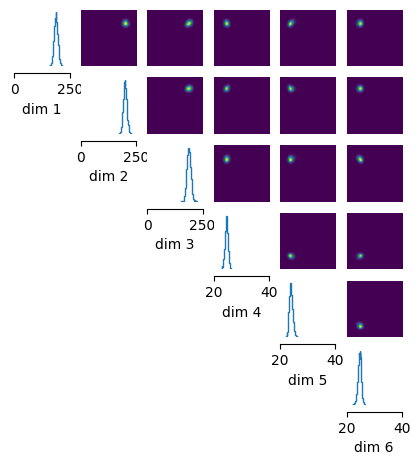

In [16]:
_ = analysis.pairplot(
    posterior_samples_sre, limits=[[0, 250], [0,250], [0,250],[20,40],[20,40],[20,40]], figsize=(5, 5)
)

# Using flattened trajectories

In [ ]:

def my_simulator_flattened(theta):
    initial_conditions = np.array([0, 2, 0, 1, 0, 3], dtype=np.float32)
    solution = odeint(model, initial_conditions, t, args=(theta,))
    return torch.tensor(solution, dtype=torch.float32).flatten()  # Flatten tensor to size [600]

In [ ]:
x_o = my_simulator_flattened(true_params) # Generate observations,with data from 100 timepoints for each of 6 variables
prior = utils.BoxUniform(low=prior_min * torch.ones(num_dim), high=prior_max * torch.ones(num_dim))
simulator, prior = prepare_for_sbi(my_simulator_flattened, prior)  

# The specific observation we want to focus the inference on.
posteriors = []
proposal = prior
inference = SNRE(prior=prior)
for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations)
    # In `SNLE` and `SNRE`, you should not pass the `proposal` to `.append_simulations()`
    density_estimator = inference.append_simulations(
        theta, x
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o) 


Running 1000 simulations.: 100%|██████████| 1000/1000 [00:21<00:00, 46.85it/s]


 Neural network successfully converged after 30 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:13<00:00, 76.01it/s]


 Neural network successfully converged after 59 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:22<00:00, 44.53it/s]


 Neural network successfully converged after 38 epochs.

In [ ]:

posterior_flattened = inference.build_posterior(sample_with=sampling_algorithm, mcmc_method=mcmc_method)
posterior_samples_sre_flattened = posterior_flattened.sample((1000,), x=x_o)  


Generating samples: 100%|██████████| 10100/10100 [06:52<00:00, 24.49it/s]


NameError: name 'posterior_samples' is not defined

In [ ]:
snre_flattened_pos = pd.DataFrame(data=posterior_samples_sre_flattened,columns=column_name)
#save to csv
snre_flattened_pos.to_csv('snre_w_flattened.csv')

In [50]:
proposal

MCMCPosterior sampler for potential_fn=<RatioBasedPotential>

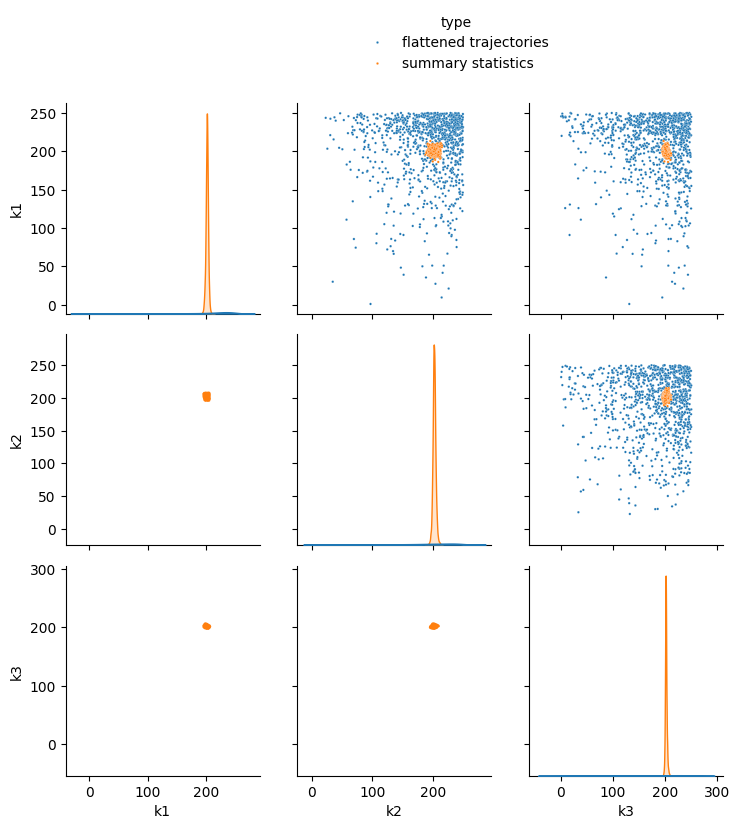

In [ ]:

import seaborn as sns
 

column_name = ['k1','k2','k3']

snre_flattened_pos = pd.DataFrame(data=posterior_samples_sre_flattened,columns=column_name)
snre_ss_pos = pd.DataFrame(data=posterior_samples_sre, columns=column_name)

snre_flattened_pos['type']="flattened trajectories"
snre_ss_pos["type"]="summary statistics"
df_joint = pd.concat([snre_flattened_pos, snre_ss_pos])
g=sns.PairGrid(df_joint, diag_sharey=False, hue="type")
g.map_diag(sns.kdeplot, fill=True, alpha=0.2)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot,s=3)
g.add_legend()
sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(.5, 1)
)

In [46]:
priors_a=np.array([[10**-2, 250],[10**-2, 250],[10**-2, 250],[20,40],[20,40],[20,40],[0,5],[0,5],[0,5],[1,5],[1,5],[1,5],[10**-2,50],[10**-2,50],[10**-2,50]])
#format prior low,high,low,high
def generate_init_cov(priors):
    """generate initial covariance matrix for the mcmc sampler"""
    init_cov=np.zeros((15,15))
    p1=priors[:,0]
    p2=priors[:,1]
    dif=1/6*np.square(np.subtract(p2,p1))
    np.fill_diagonal(init_cov, dif)
    return(init_cov)

In [47]:
ini=generate_init_cov(priors_a)

In [48]:
print(ini)

[[1.04158334e+04 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.04158334e+04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.04158334e+04 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.66666667e+01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  